In [1]:
import sys
curr_dir ='/home/users/maali/Computer_vision_SOC'
source ='/home/users/maali/Computer_vision_SOC/source'
sys.path.append(curr_dir)
sys.path.append(source)

import os
from Preprocessor import Preprocessor
from Sampler import Sampler 
from ObjectDetection import ObjectDetector 
from imageProcessor import ImageProcessor 
from ultralytics import YOLO
from ultralytics import YOLO 
import pandas as pd 
import numpy as np 
import cv2
import yaml

def convert_bbox_normalize(bbox, img_width=800, img_height=600):
    xmin, ymin, xwidth, yheight = bbox
    centerx = (xmin + xwidth / 2) / img_width
    centery = (ymin + yheight / 2) / img_height
    norm_xwidth = xwidth / img_width
    norm_yheight = yheight / img_height
    return [centerx, centery, norm_xwidth, norm_yheight]

file_path = "/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/sim_data_annotations.yaml"

with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

filenames = []
classes = []
bboxes= []

for entry in data:
    filename = entry['filename'].strip('sim_data_capture/')
     
    if entry['annotations']:
        for annotation in entry['annotations']:
            filenames.append(filename)
            classes.append(annotation['class'])
            bboxes.append([annotation['xmin'], annotation['ymin'], annotation['x_width'], annotation['y_height']])

    else:
        filenames.append(filename)
        classes.append(np.nan)
        bboxes.append(np.nan)

data_df = pd.DataFrame({
    'filename': filenames,
    'class': classes,
    'bbox': bboxes
})


processor = Preprocessor()
data = data_df.copy().dropna()

data['bbox'] = data['bbox'].apply(convert_bbox_normalize)
all_labels = data['class'].unique()
processor.make_numeric_class(data)


train_data_pd,val_data_pd = processor.make_train_val_dfs(data,train_size=0.90)

backgrounds = data_df[data_df['class'].isna()]

processor.move_files_to_val_directory(val_data_pd,
                                      source_directory= "/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val",
                                      destination_directory ="/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images")

processor.move_files_to_val_directory(pd.concat([train_data_pd,backgrounds]),
                                      source_directory= "/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/train",
                                      destination_directory ="/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/train/images")


processor.Yolo_labels_maker(train_data_pd,'/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/train/labels',skip=False,yolo_format=True,keep=False)
processor.Yolo_labels_maker(val_data_pd,'/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/labels',skip=False,yolo_format=True,keep=False)

validation images already exist, skipping...
validation images already exist, skipping...
yolo-format labels  made..
yolo-format labels  made..


Displaying images for class: Green


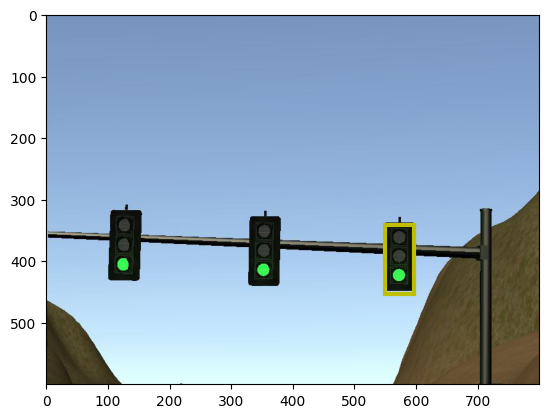

Displaying images for class: Red


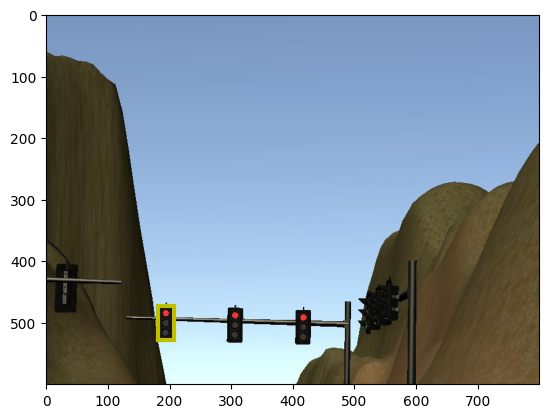

Displaying images for class: Yellow


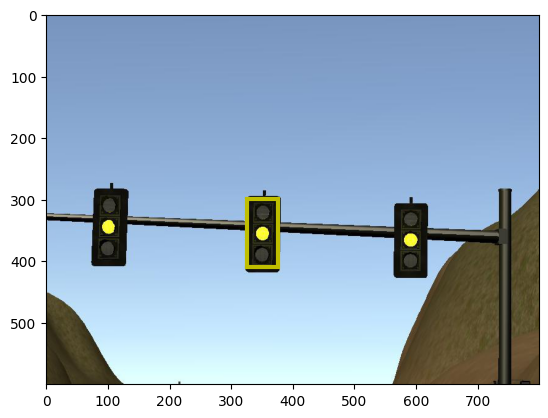

In [2]:
processor.show_image_per_class(train_data_pd,'/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/train/images',yolo_box_ready=True)

Displaying images for class: Green


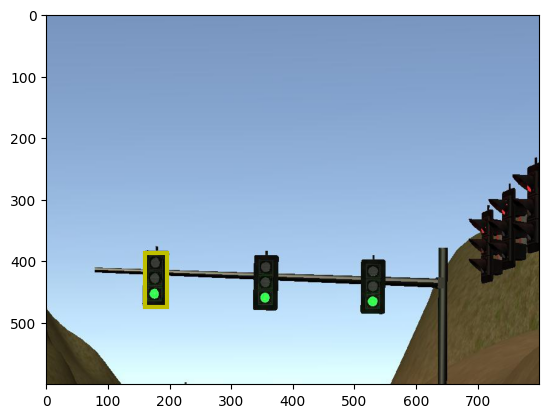

Displaying images for class: Red


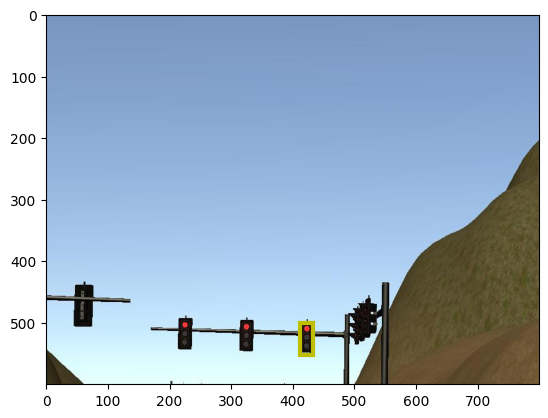

Displaying images for class: Yellow


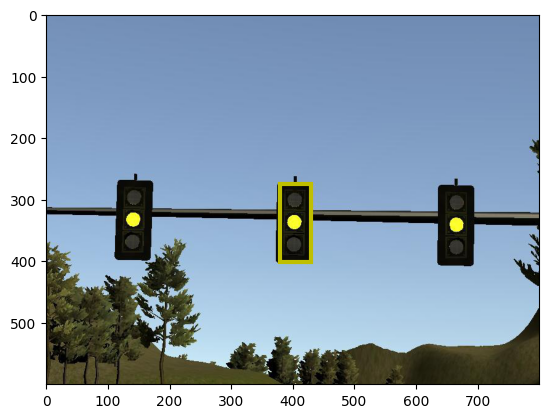

In [3]:
processor.show_image_per_class(val_data_pd,'/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images',yolo_box_ready=True)

In [23]:
train_data_pd[train_data_pd.filename == 'left1130.jpg']

,filename,class,bbox,num_labels
369,left0526.jpg,Red,"[0.39575167581466353, 0.8347457623280617, 0.03...",2
207,left0472.jpg,Red,"[0.31261157126681993, 0.951492307603099, 0.013...",2
18,left0016.jpg,Yellow,"[0.1848, 0.5669333333333333, 0.062400000000000...",1
479,left0563.jpg,Green,"[0.1561266043736086, 0.6133573613290146, 0.064...",0
176,left0461.jpg,Red,"[0.5923732449033856, 0.9731533310102, 0.011706...",2
...,...,...,...,...
69,left0033.jpg,Red,"[0.0662, 0.32666666666666666, 0.09720000000000...",2
577,left0595.jpg,Red,"[0.7624113475177308, 0.5620803782505912, 0.066...",2
187,left0465.jpg,Red,"[0.47423306760767103, 0.9683751640821628, 0.01...",2
678,left0969.jpg,Red,"[0.4056358732525021, 0.9250214887398329, 0.020...",2


In [4]:
import wandb
wandb.init(dir="/home/users/maali/TRAFFICLIGHTDETECTION")

detector = ObjectDetector(data ="/home/users/maali/TRAFFICLIGHTDETECTION/config.yaml",model = 'yolov8n.pt')

detector.train_yolo_model(epochs=150,patience =30,imgsz =512, batch = 8,lr0=0.001 ,optimizer = 'Adam',project='detect_tf',max_det=3,save_dir='/home/users/maali/TRAFFICLIGHTDETECTION')  

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mahmud-ali-001 (indi-team). Use `wandb login --relogin` to force relogin


Ultralytics YOLOv8.0.232 🚀 Python-3.8.6 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/users/maali/TRAFFICLIGHTDETECTION/config.yaml, epochs=150, time=None, patience=30, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=detect_tf, name=train6, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=3, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

train: Scanning /mnt/irisgpfs/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/train/labels... 176 images, 43 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<00:00, 1563.84it/s]

train: New cache created: /mnt/irisgpfs/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/train/labels.cache



/mnt/irisgpfs/users/maali/ultra_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /mnt/irisgpfs/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/labels... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<00:00, 315.26it/s]


val: New cache created: /mnt/irisgpfs/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/labels.cache


/mnt/irisgpfs/users/maali/ultra_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Plotting labels to detect_tf/train6/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.51G      1.322      3.438     0.9467         43        512: 100%|██████████| 14/14 [00:02<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         58         67     0.0632       0.22     0.0602     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.52G      1.045      2.083     0.9095         30        512: 100%|██████████| 14/14 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]

                   all         58         67     0.0694       0.24     0.0786     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.53G      1.029      1.708     0.9224         18        512: 100%|██████████| 14/14 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.34it/s]

                   all         58         67     0.0727       0.24     0.0828     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.53G     0.9935      1.464     0.8957         59        512: 100%|██████████| 14/14 [00:01<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]

                   all         58         67      0.119      0.413      0.119     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.53G     0.9574      1.208     0.8961         48        512: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.16it/s]

                   all         58         67      0.135      0.507      0.144     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.53G     0.9589      1.136     0.8896         21        512: 100%|██████████| 14/14 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]

                   all         58         67      0.379      0.611      0.569      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.52G     0.9654     0.9615     0.8951         38        512: 100%|██████████| 14/14 [00:00<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]

                   all         58         67      0.373       0.91      0.523      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.53G     0.9689     0.9398     0.9002         35        512: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]

                   all         58         67      0.372      0.993      0.481      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.52G     0.9594     0.8488     0.9152         32        512: 100%|██████████| 14/14 [00:01<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]

                   all         58         67      0.412      0.967      0.517      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.53G     0.9749      0.788     0.8984         34        512: 100%|██████████| 14/14 [00:01<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]

                   all         58         67      0.428      0.873      0.511      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.52G     0.9473     0.7273     0.9092         41        512: 100%|██████████| 14/14 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]

                   all         58         67       0.42      0.967      0.506      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.53G     0.9634     0.7408     0.8883         34        512: 100%|██████████| 14/14 [00:00<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         58         67      0.404      0.909      0.567      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.52G     0.9297     0.6901     0.8892         42        512: 100%|██████████| 14/14 [00:01<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.45it/s]

                   all         58         67      0.406      0.912      0.549      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.53G     0.9391     0.6563      0.894         41        512: 100%|██████████| 14/14 [00:01<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.91it/s]

                   all         58         67      0.391      0.987      0.513      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.52G     0.9172     0.6409     0.8916         46        512: 100%|██████████| 14/14 [00:01<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]

                   all         58         67      0.391      0.993       0.56      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.53G     0.9353     0.6603     0.8952         37        512: 100%|██████████| 14/14 [00:00<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]

                   all         58         67      0.389      0.992      0.486      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.52G     0.9012     0.6351     0.8846         43        512: 100%|██████████| 14/14 [00:00<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.08it/s]

                   all         58         67      0.388       0.98      0.509      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.53G     0.9084     0.6255      0.881         31        512: 100%|██████████| 14/14 [00:01<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]

                   all         58         67      0.391      0.993      0.494      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.52G     0.8924     0.6359     0.8903         48        512: 100%|██████████| 14/14 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.17it/s]

                   all         58         67      0.387      0.987      0.515      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.53G     0.8949     0.6054     0.8899         49        512: 100%|██████████| 14/14 [00:00<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.96it/s]

                   all         58         67       0.39      0.987      0.424      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.52G     0.8965      0.616     0.8847         48        512: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]

                   all         58         67      0.391      0.993       0.52       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.53G     0.8872     0.5942     0.8929         38        512: 100%|██████████| 14/14 [00:01<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

                   all         58         67      0.388      0.993      0.576      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.52G     0.8681      0.585     0.8881         44        512: 100%|██████████| 14/14 [00:00<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         58         67      0.392       0.96      0.557      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.53G     0.8597     0.5666      0.883         28        512: 100%|██████████| 14/14 [00:01<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]

                   all         58         67      0.391      0.985        0.6       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.52G     0.8598     0.5999     0.8846         26        512: 100%|██████████| 14/14 [00:01<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

                   all         58         67      0.388      0.993      0.631      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.53G     0.9055     0.5699     0.8828         45        512: 100%|██████████| 14/14 [00:01<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         58         67      0.386      0.998       0.61      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.52G     0.8193     0.5256     0.8734         60        512: 100%|██████████| 14/14 [00:01<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.05it/s]

                   all         58         67      0.386       0.99      0.501      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.53G     0.8875      0.586     0.8908         47        512: 100%|██████████| 14/14 [00:01<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.08it/s]

                   all         58         67      0.388      0.993      0.461      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.52G     0.8655     0.5373     0.8725         32        512: 100%|██████████| 14/14 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.29it/s]

                   all         58         67      0.384      0.993      0.486      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.53G     0.8745     0.5526     0.8962         47        512: 100%|██████████| 14/14 [00:01<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.85it/s]

                   all         58         67      0.388      0.993       0.47      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.52G     0.8759     0.5546     0.8891         43        512: 100%|██████████| 14/14 [00:00<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

                   all         58         67      0.385      0.993      0.481      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.53G     0.8756     0.5471     0.8767         40        512: 100%|██████████| 14/14 [00:01<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]

                   all         58         67      0.389       0.98      0.485      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.52G     0.8728     0.5342     0.8782         41        512: 100%|██████████| 14/14 [00:01<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]

                   all         58         67       0.39       0.98      0.487      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.53G     0.8534      0.535     0.8904         36        512: 100%|██████████| 14/14 [00:01<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

                   all         58         67      0.388      0.987      0.506      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.52G     0.8273     0.5304     0.8714         49        512: 100%|██████████| 14/14 [00:01<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         58         67      0.391      0.984      0.537      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.53G     0.8456     0.5145     0.8883         60        512: 100%|██████████| 14/14 [00:01<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]

                   all         58         67      0.391      0.985      0.515      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.52G     0.8812     0.5287     0.8826         52        512: 100%|██████████| 14/14 [00:01<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.41it/s]

                   all         58         67      0.405      0.953      0.516      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.53G     0.8331     0.5176     0.8874         27        512: 100%|██████████| 14/14 [00:01<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]

                   all         58         67      0.389      0.987      0.513        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.52G     0.8587     0.5126     0.8788         45        512: 100%|██████████| 14/14 [00:00<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.29it/s]

                   all         58         67      0.391      0.993      0.576      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.53G     0.9008     0.5581     0.8846         40        512: 100%|██████████| 14/14 [00:01<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.18it/s]

                   all         58         67       0.39      0.989      0.583      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.52G     0.8612     0.5236     0.8772         35        512: 100%|██████████| 14/14 [00:00<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.34it/s]

                   all         58         67       0.39      0.993      0.514      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.53G     0.8662     0.5088      0.884         40        512: 100%|██████████| 14/14 [00:01<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]

                   all         58         67       0.39      0.973      0.495      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.52G     0.8695     0.5009     0.8942         50        512: 100%|██████████| 14/14 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.88it/s]

                   all         58         67      0.388      0.967      0.533      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.53G     0.8731     0.5168     0.8699         41        512: 100%|██████████| 14/14 [00:00<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]

                   all         58         67      0.388      0.985      0.632       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.52G     0.8324     0.4707     0.8855         42        512: 100%|██████████| 14/14 [00:00<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]

                   all         58         67      0.391      0.986      0.625      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.53G     0.8481     0.4814     0.8765         32        512: 100%|██████████| 14/14 [00:00<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         58         67      0.386      0.927      0.634      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.52G     0.8436     0.4754     0.8781         31        512: 100%|██████████| 14/14 [00:00<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         58         67      0.394      0.993      0.502      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.53G     0.8261     0.4805     0.8807         41        512: 100%|██████████| 14/14 [00:01<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

                   all         58         67      0.391      0.993      0.475      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.52G     0.8779     0.5025     0.8815         50        512: 100%|██████████| 14/14 [00:00<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         58         67       0.39      0.987      0.495      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.53G     0.8191     0.4864     0.8735         45        512: 100%|██████████| 14/14 [00:00<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.92it/s]

                   all         58         67      0.391      0.993      0.501      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.52G     0.8563     0.4765     0.8815         44        512: 100%|██████████| 14/14 [00:00<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.03it/s]

                   all         58         67      0.391      0.993      0.494      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.53G     0.8765     0.4785     0.8912         35        512: 100%|██████████| 14/14 [00:01<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]

                   all         58         67      0.392      0.973      0.492      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.52G     0.8587     0.4839     0.8838         49        512: 100%|██████████| 14/14 [00:00<00:00, 15.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.24it/s]

                   all         58         67      0.392      0.987      0.526      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.53G     0.8532     0.5028     0.8735         46        512: 100%|██████████| 14/14 [00:01<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.14it/s]

                   all         58         67      0.391      0.986      0.547      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.52G     0.8393     0.4608     0.8796         41        512: 100%|██████████| 14/14 [00:00<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]

                   all         58         67      0.388       0.98      0.515      0.393
Stopping training early as no improvement observed in last 30 epochs. Best results observed at epoch 25, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



55 epochs completed in 0.027 hours.
Optimizer stripped from detect_tf/train6/weights/last.pt, 6.2MB
Optimizer stripped from detect_tf/train6/weights/best.pt, 6.2MB

Validating detect_tf/train6/weights/best.pt...
Ultralytics YOLOv8.0.232 🚀 Python-3.8.6 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


                   all         58         67      0.388      0.993      0.624      0.481
                 Green         58          4      0.333          1      0.888      0.666
                Yellow         58         13      0.433          1      0.547      0.475
                   Red         58         50      0.396       0.98      0.438        0.3
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to detect_tf/train6


lr/pg0,█▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▁▂▃▆▇███████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆
lr/pg2,▁▂▃▆▇███████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆
metrics/mAP50(B),▁▁▁▂▇▇▇▆▇▇▇▆▆▇▅▇▇██▆▆▆▆▆▆▇▇▇▇▇▆▇██▆▆▆▆▇█
metrics/mAP50-95(B),▁▁▁▂▇▆▆▆▇▇▇▆▆▆▅▆▇██▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▆▆▆▆▇█
metrics/precision(B),▁▁▁▂▇▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇
metrics/recall(B),▁▁▁▄▅▇█▇▇▇███████████████████████▇██████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▂▂▂▂▁▁▁▂▁▂▂▁


In [16]:
def enhance_image(path):
    image = cv2.imread(path)

    alpha = 2.5  # Contrast control (1.0-3.0)
    beta = 0    # Brightness control (0-100)

    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Split the image into its B, G, and R components
    B, G, R = cv2.split(image)

    # Define the increase you want in the red channel
    increase = 50

    # Increase the red channel by the increase value
    # and ensure the values remain between 0 and 255
    R = cv2.add(R, increase)
    R[R > 255] = 255

    # Merge the channels back together
    enhanced_reds = cv2.merge([B, G, R])
   
    return enhanced_reds

def predict_with_yolo(test_images_dir,all_labels,model = '/home/users/maali/Computer_vision_SOC/runs/detect/train/weights/best.pt',imgsiz = 256,device=0,max_det=3):
        # Perform predictions with the YOLO model
        def convert_bbox_to_corners(bbox):
            
            x_center, y_center, width, height = bbox

            x1 = x_center - (width / 2)
            y1 = y_center - (height / 2)
            x2 = x_center + (width / 2)
            y2 = y_center + (height / 2)

            return [y1, x1, y2, x2]
        
        
        
        model = YOLO(model)
        res = model.predict(
            source=test_images_dir,
            stream=True,
            project='/home/users/maali/Computer_vision_SOC/runs/detect/predictions',
            max_det = 1,
            imgsz = imgsiz,
            batch = 16,
        )
        
        imgs = []
        pred_labels = []
        preds_bbox = []
        nodetects = []

        for r in res:
            name = os.path.basename(r.path)
            boxes = r.boxes.cpu().numpy()
            if len(boxes.cls) > 0:
                max_conf = boxes.conf.max()
                idx = np.where(boxes.conf == max_conf)[0][0]
                label_idx = int(boxes.cls[idx])
                label = all_labels[label_idx]
                bbox = boxes.xywh[idx]
                bbox = convert_bbox_to_corners(bbox)
                pred_labels.append(label)
                preds_bbox.append(bbox)
            else:
                nodetects.append(r.path)   
                pred_labels.append('no detection')
                preds_bbox.append('no detection')
                

            imgs.append(name)

        preds_df = pd.DataFrame({'filename': imgs, 'class': pred_labels,'bbox':preds_bbox})
        
        print('running second round of predictions with enhancement')
        print(f" Number of no detections : {len(nodetects)}")
        
        imgs = []
        pred_labels = []
        preds_bbox = []
        
        for path in nodetects:
             print(path)
             enhanced_image = enhance_image(path)
             
             res = model.predict(
                source=enhanced_image,
                stream=True,
                project='/home/users/maali/Computer_vision_SOC/runs/detect/predictions',
                max_det = max_det,
                imgsz = imgsiz,
                batch = 16, 
             )
             
              
             for r in res:
                name = os.path.basename(path)
                boxes = r.boxes.cpu().numpy()
                if len(boxes.cls) > 0:
                    max_conf = boxes.conf.max()
                    idx = np.where(boxes.conf == max_conf)[0][0]
                    label_idx = int(boxes.cls[idx])
                    label = all_labels[label_idx]
                    bbox = boxes.xywh[idx]
                    bbox = convert_bbox_to_corners(bbox)
                    pred_labels.append(label)
                    preds_bbox.append(bbox)
                else:
                    pred_labels.append('no detection')
                    preds_bbox.append('no detection')
                

                imgs.append(name)

        preds_df_2 = pd.DataFrame({'filename': imgs, 'class': pred_labels,'bbox':preds_bbox})
             
        combined_df = pd.merge(preds_df, preds_df_2, on='filename', how='outer', suffixes=('_orig', '_new'))
        for column in preds_df.columns:
            if column != 'filename':
                # Create a new column without a suffix, which will be our final column.
                combined_df[column] = combined_df[column + '_new'].combine_first(combined_df[column + '_orig'])

        # Now, drop the intermediary columns with suffixes.
        columns_to_drop = [col for col in combined_df if col.endswith('_orig') or col.endswith('_new')]
        combined_df = combined_df.drop(columns=columns_to_drop)   

        return combined_df


In [33]:
test_images ="/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images"

predictions_df = predict_with_yolo(test_images,all_labels,model = '/home/users/maali/detect_tf/train6/weights/best.pt', imgsiz=512,max_det=3)

true_df = val_data_pd[['filename','class','bbox']]
overall_dict,class_wise_stats,merged_df = detector.classification_report(true_df,predictions_df,all_labels)
iou_scores = detector.iou_report(true_df, predictions_df,all_labels)


image 1/58 /home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images/left0018.jpg: 384x512 1 Yellow, 7.8ms
image 2/58 /home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images/left0021.jpg: 384x512 1 Yellow, 7.1ms
image 3/58 /home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images/left0026.jpg: 384x512 1 Red, 7.0ms
image 4/58 /home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images/left0029.jpg: 384x512 1 Red, 7.7ms
image 5/58 /home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images/left0033.jpg: 384x512 1 Red, 6.8ms
image 6/58 /home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images/left0037.jpg: 384x512 1 Red, 6.8ms
image 7/58 /home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images/left0039.jpg: 384x512 1 Red, 6.8ms
image 8/58 /home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/val/images/left0431.jpg: 384x512 (no detections), 6.7ms
image 9/58 /home/users/

In [34]:
path = "/home/users/maali/TRAFFICLIGHTDETECTION/sim_training_data/data/train/images/left0563.jpg"


def get_traffic_light(model_path,image):

    model = YOLO(model_path)
    
    image = cv2.imread(image)
    alpha = 2.5  # Contrast control (1.0-3.0)
    beta = 0    # Brightness control (0-100)
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    # Split the image into its B, G, and R components
    B, G, R = cv2.split(image)
    # Define the increase you want in the red channel
    increase = 8
    # Increase the red channel by the increase value
    # and ensure the values remain between 0 and 255
    R = cv2.add(R, increase)
    R[R > 255] = 255
    # Merge the channels back together
    enhanced_reds = cv2.merge([B, G, R])

    #detection
    result  = model.predict(
        source=enhanced_reds,
        save=True,
        project='/home/users/maali/TRAFFICLIGHTDETECTION/predictions',
        max_det = 1,
    )
    all_labels = ["Green","Yellow","Red"]

    color = None

    for r in result:
        boxes = r.boxes.cpu().numpy()
        if len(boxes.cls) > 0:
            max_conf = boxes.conf.max()
            idx = np.where(boxes.conf == max_conf)[0][0]
            label_idx = int(boxes.cls[idx])
            color = all_labels[label_idx]
    
    return color
        

color = get_traffic_light('/home/users/maali/detect_tf/train6/weights/best.pt',path)        



0: 384x512 1 Green, 7.6ms
Speed: 3.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 512)
Results saved to /home/users/maali/TRAFFICLIGHTDETECTION/predictions/predict18


'Green'